In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import seaborn as sns

In [3]:
from movienet import MovieNet

Using TensorFlow backend.


## Loading datasets

In [4]:
# PATH = Path("data/ml-latest-small")
PATH = Path("data/ml-20m")

In [5]:
ratings_raw = pd.read_csv(PATH/"ratings.csv")
movies_raw = pd.read_csv(PATH/"movies.csv")

In [6]:
def load_obj(name):  
    with open(Path("model")/str(name+'.pkl'), 'rb') as f:
        return pickle.load(f)

user2idx = load_obj("user2idx")
idx2user = load_obj("idx2user")
movie2idx = load_obj("movie2idx")
idx2movie = load_obj("idx2movie")

In [8]:
ratings = ratings_raw.copy()
ratings["userId"] = ratings["userId"].apply(lambda x: user2idx[x])
ratings["movieId"] = ratings["movieId"].apply(lambda x: movie2idx[x])

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,3.5,1112486027
1,0,1,3.5,1112484676
2,0,2,3.5,1112484819
3,0,3,3.5,1112484727
4,0,4,3.5,1112484580


In [15]:
n_users = len(user2idx)
n_movies = len(movie2idx)
n_users, n_movies

(138493, 26744)

## Recomanding movies by evaluating the model

In [16]:
movie_model = MovieNet(n_users, n_movies)
movie_model.load_model(name="movie_model")

In [17]:
X_pred = pd.DataFrame({"userId": [0 for _ in range(n_movies)], "movieId": [i for i in range(n_movies)]})

In [22]:
def predict_user(user_id):
    X_pred["userId"] = X_pred.userId.apply(lambda x: user_id)
    preds = movie_model.predict(X_pred)
    df_preds = pd.DataFrame({"pred": preds, "movieId": [i for i in range(n_movies)],
                             "title": [movies_raw.loc[movies_raw.movieId == idx2movie[i]]["title"].values[0] for i in range(n_movies)]})
    return df_preds

def suggest_user(user_id, m=10):
    preds = predict_user(user_id)
    preds.sort_values("pred", ascending=False, inplace=True)
    r = ratings[ratings.userId == 0]["movieId"].values
    preds.drop(r, axis=0, inplace=True)
    return preds.drop("movieId", axis=1)[:m]

def user_rating(user_id):
    preds = predict_user(user_id)
    return pd.merge(ratings[ratings.userId == user_id][["rating", "movieId"]], preds, on="movieId")

In [51]:
user_id = np.random.randint(0, n_users)
user_id

74962

In [76]:
preds = user_rating(user_id).sort_values("rating", ascending=False)[:]
preds

,rating,movieId,pred,title
18,5.0,9,4.127039,Star Wars: Episode IV - A New Hope (1977)
51,5.0,652,4.289676,Schindler's List (1993)
89,5.0,24,3.993262,Monty Python's Life of Brian (1979)
82,5.0,2000,3.640464,Fly Away Home (1996)
77,5.0,454,3.961872,My Fair Lady (1964)
74,5.0,184,3.969764,North by Northwest (1959)
104,5.0,30,3.967915,Star Wars: Episode V - The Empire Strikes Back...
105,5.0,261,4.243433,"Princess Bride, The (1987)"
70,5.0,2145,3.757059,"Spitfire Grill, The (1996)"
49,5.0,443,3.856722,"Piano, The (1993)"


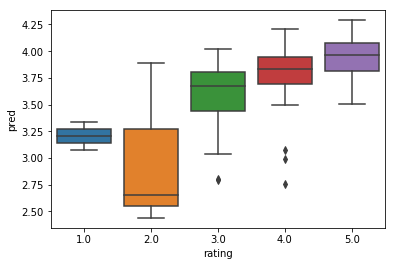

In [83]:
sns.boxplot(preds["rating"], preds["pred"])

The predicted rating are a bit off, with some extreme values such as 4 stars movies predicted at ~2.75.
The variance for 2 stars movies is to big.

In [53]:
suggest_user(user_id)

,pred,title
9260,4.523907,Connections (1978)
5269,4.505244,Black Mirror (2011)
5265,4.478286,Cosmos (1980)
8248,4.427635,North & South (2004)
9321,4.427304,Fawlty Towers (1975-1979)
1285,4.403131,"Lives of Others, The (Das leben der Anderen) (..."
1272,4.390732,"Best of Youth, The (La meglio gioventù) (2003)"
2086,4.389865,Band of Brothers (2001)
5268,4.377007,"Civil War, The (1990)"
7836,4.373244,Dylan Moran: Monster (2004)


Some of those suggestions are good, but as we saw above the predicted ratings can be off.

## Recommanding movies using KNN on embedding spaces
In this section we uses KNN to find close neighbourd of a movie or a user in their embedding spaces.


In [37]:
import nmslib

### Looking at movies embedding space

In [41]:
movies_index = nmslib.init(space='angulardist', method='hnsw')
movies_index.addDataPointBatch(movie_model.model.get_layer("movies").get_weights()[0])

26744

In [42]:
M = 100
efC = 1000
efS = 1000
num_threads = 6
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
query_time_params = {'efSearch': efS}

In [43]:
movies_index.createIndex(index_time_params)
movies_index.setQueryTimeParams(query_time_params)

In [45]:
def get_knns(index, vecs, n_neighbour):
     return zip(*index.knnQueryBatch(vecs, k=n_neighbour, num_threads=6))

def get_knn(index, vec, n_neighbour):
    return index.knnQuery(vec, k=n_neighbour)

def suggest_movies_knn(movieId, n_suggest = 5):
    res = get_knn(movies_index, movie_model.model.get_layer("movies").get_weights()[0][movieId], n_suggest)[0]
    return movies_raw[movies_raw.movieId.isin([idx2movie[i] for i in res])]

user 19494 loved the movie "Star Wars: Episode IV - A New Hope", let see what movies that are closes in the embedding space.

In [55]:
movie_id = 9 # movieId of Star Wars: Episode IV - A New Hope
suggest_movies_knn(movie_id, 10)

,movieId,title,genres
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1171,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
1173,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
1184,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
1944,2028,Saving Private Ryan (1998),Action|Drama|War
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5252,5349,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller
5853,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7041,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
12525,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX


All the recommandations are in the same genres, with a few variations.
We have the two others star wars movies from the trilogy, which is a good fit.
The lord of the Rings trilogy is also an epic adventure trilogy but in fantasy not sci-fi.
Raiders of the Lost Ark, is a good action-adventure movie with the same major actor playing a major role in star wars.
A part of Saving Private Ryan, all movies are part of a trylogy.

### Looking at users embedding space

In [70]:
users_index = nmslib.init(space='angulardist', method='hnsw')
users_index.addDataPointBatch(movie_model.model.get_layer("users").get_weights()[0])

138493

In [71]:
M = 100
efC = 1000
efS = 1000
num_threads = 6
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
query_time_params = {'efSearch': efS}

In [72]:
users_index.createIndex(index_time_params)
users_index.setQueryTimeParams(query_time_params)

In [73]:
def suggest_users_knn(user_id, n_suggest = 5):
    res = get_knn(users_index, movie_model.model.get_layer("users").get_weights()[0][user_id], n_suggest)[0]
    for uid in res[1:]:
        moviesId = ratings[ratings.userId == uid].sort_values("rating", ascending=False)[:10]["movieId"].values
        print("From user", uid, ": ")
        display(movies_raw[movies_raw.movieId.isin([idx2movie[i] for i in moviesId])])

In [74]:
suggest_users_knn(user_id)

From user 45925 : 


,movieId,title,genres
1179,1204,Lawrence of Arabia (1962),Adventure|Drama|War
1875,1959,Out of Africa (1985),Drama|Romance
2311,2396,Shakespeare in Love (1998),Comedy|Drama|Romance
2600,2686,"Red Violin, The (Violon rouge, Le) (1998)",Drama|Mystery
3320,3408,Erin Brockovich (2000),Drama
3379,3468,"Hustler, The (1961)",Drama
3487,3578,Gladiator (2000),Action|Adventure|Drama
4899,4995,"Beautiful Mind, A (2001)",Drama|Romance
4914,5010,Black Hawk Down (2001),Action|Drama|War
5386,5483,"Kid Stays in the Picture, The (2002)",Documentary


From user 95301 : 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1839,1923,There's Something About Mary (1998),Comedy|Romance
4211,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
4877,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
4899,4995,"Beautiful Mind, A (2001)",Drama|Romance
6271,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
7249,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
7761,8360,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...
9568,30707,Million Dollar Baby (2004),Drama
9582,30793,Charlie and the Chocolate Factory (2005),Adventure|Children|Comedy|Fantasy|IMAX


From user 33127 : 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
108,110,Braveheart (1995),Action|Drama|War
166,168,First Knight (1995),Action|Drama|Romance
221,224,Don Juan DeMarco (1995),Comedy|Drama|Romance
227,230,Dolores Claiborne (1995),Drama|Thriller
245,248,Houseguest (1994),Comedy
250,253,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
258,261,Little Women (1994),Drama
262,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance
345,349,Clear and Present Danger (1994),Action|Crime|Drama|Thriller


From user 77097 : 


,movieId,title,genres
1149,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
1625,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
3920,4014,Chocolat (2000),Drama|Romance
5121,5218,Ice Age (2002),Adventure|Animation|Children|Comedy
5519,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
6271,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
8885,26502,"Christmas Carol, A (1984)",Drama|Fantasy
13172,63876,Milk (2008),Drama
15203,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX
16936,85736,BURN-E (2008),Adventure|Animation|Children|Sci-Fi


Suggestions from users close in the embedding spaces are not goods.
Those could be better if more informations were provided in the training such as age, genre, location,...